In [65]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import itertools
import importlib
import config
importlib.reload(config)
from config import BIN_SIZE as bin_size
from config import ANALYSIS_MODE as analysis_mode
from config import SPECIFIC_GROUP as specific_group
from config import STRATIFY_BY as stratify

# 0. Check Config

In [66]:
print(analysis_mode)
print(specific_group)
print(bin_size)

all_vs_healthy
Pancreatic Cancer
100000


# 1. Loading of Dataframes

In [67]:
matrix_path = f"/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/final_feature_matrix_gc_corrected_{bin_size}.tsv"
df = pd.read_csv(matrix_path, sep="\t")

clinical_path = "/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/filtered_clinical_characteristics.csv"
clinical_df_raw = pd.read_csv(clinical_path, sep=";")

if analysis_mode == "specific_vs_healthy":
    clinical_df = clinical_df_raw[
            (clinical_df_raw["Patient Type"] == specific_group) |
            (clinical_df_raw["Patient Type"].str.lower() == "healthy")
        ].copy()
else:
    clinical_df = clinical_df_raw.copy()

if stratify =="Gender":
    clinical_df = clinical_df[clinical_df["Gender"].isin(["M", "F"])]
else:
    clinical_df = clinical_df
# Balancing: Sample as many Healthy as there are Cancer samples
cancer_df = clinical_df[clinical_df["Patient Type"].str.lower() != "healthy"]
print(cancer_df.shape)
healthy_df = clinical_df[clinical_df["Patient Type"].str.lower() == "healthy"]
print(healthy_df.shape)
n_cancer = len(cancer_df)

healthy_df = healthy_df.sample(n=n_cancer, random_state=42)
clinical_df = pd.concat([cancer_df, healthy_df]).copy()
print(len(healthy_df))
print(len(cancer_df))

valid_samples = clinical_df["Extracted_ID"].unique()
df = df[df["sample"].isin(valid_samples)].copy()

print(f"Number of Samples in Matrix: {df['sample'].nunique()}")
print(f"Number of Bins per Sample: {len(df) / df['sample'].nunique()}")


(115, 19)
(129, 19)
115
115
Number of Samples in Matrix: 230
Number of Bins per Sample: 3872.0


# 2. Pipeline for LASSO

In [68]:
C_values = np.logspace(-4, 4, 50)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso_cv', LogisticRegressionCV(
        Cs=C_values,
        penalty='l1',
        solver='liblinear',
        cv=5,
        scoring='roc_auc',
        max_iter=10000,
        random_state=42
    ))
])

# 3. General Function for LASSO perfomance

In [69]:
def run_lasso_for_metrics(df, clinical_df, metrics, pipeline):
    # Pivot
    pivot_df = df.pivot(
        index="sample",
        columns="bin_id",
        values=list(metrics)
    )
    pivot_df.columns = [
        f"{metric}_{bin_id}" for metric, bin_id in pivot_df.columns
    ]

    # Labels and Stratification
    y = []
    strata = []

    for sample_id in pivot_df.index:
        row = clinical_df[clinical_df["Extracted_ID"] == sample_id].iloc[0]
        
        is_healthy = row["Patient Type"].lower() == "healthy"
        target_val = 0 if is_healthy else 1
        y.append(target_val)
        
        if stratify == "Gender":
            strata.append(row["Gender"])
        else:
            strata.append(target_val)

    y = np.array(y)
    X = pivot_df


    print(f"Number Cancer: {sum(y)}")
    print(f"Number Healthy: {len(y) - sum(y)}")

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=strata,
        random_state=42
    )

    # Fit
    pipeline.fit(X_train, y_train)

    # Predict
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)

    # Coefficients
    lasso_model = pipeline.named_steps['lasso_cv']
    n_selected = np.sum(lasso_model.coef_[0] != 0)

    return {
        "metrics": metrics,
        "n_metrics": len(metrics),
        "n_features": X.shape[1],
        "n_selected_features": int(n_selected),
        "roc_auc": auc_score,
        "best_C": lasso_model.C_[0]
    }


# 4. Feature Selektion for LASSO (combinations of metrics)

In [70]:
df["bin_id"] = df["chrom"] + "_" + df["start"].astype(str)

'''metrics = [
    "mean", 
    "median", 
    "stdev", 
    "wps_value",
    "min",
    "max",	
]

metrics_results =[]

for r in range (1, len(metrics) + 1):
    for combination in itertools.combinations(metrics, r):
        res = run_lasso_for_metrics(df, clinical_df, combination, pipeline)
        metrics_results.append(res)

print(pd.DataFrame(metrics_results).columns)
print(metrics_results[0].keys())

metrics_results = pd.DataFrame(metrics_results).sort_values("roc_auc", ascending=False)
metrics_results.to_csv("/labmed/workspace/lotta/finaletoolkit/dataframes_notebooklasso_metrics_results.csv", index=False)

print("10 Best metric combinations:")
print(metrics_results.head(10))

best_metrics = metrics_results.iloc[0]['metrics']
print("Best metrics:", best_metrics)'''
metrics_results = ['mean']
best_metrics = metrics_results


# 5. Influence of metric selection on model performance

In [71]:
'''metrics_results.groupby("n_metrics")["roc_auc"].mean().plot(
    title="Mean ROC AUC vs Number of Metrics",
    ylabel="ROC AUC",
    xlabel="Number of Metrics"
)'''

'metrics_results.groupby("n_metrics")["roc_auc"].mean().plot(\n    title="Mean ROC AUC vs Number of Metrics",\n    ylabel="ROC AUC",\n    xlabel="Number of Metrics"\n)'

### 5.1 Lasso Modeling with best C parameter 

The `LogisticRegressionCV` model automatically tried out different values for the parameter `C`. 
Here we visualize how the accuracy of the model changes with `C`.

- **Small C**: Strong regularization (model is “forced” to find simple solutions). Risk of underfitting.
- **Large C**: Weak regularization (model can be more complex). Risk of overfitting.
- **Best C**: The value that achieved the best balance and thus the highest score in cross-validation (CV).

The Reciever operating characteristic curve plots the true positive (TP) rate versus the false positive (FP) rate at different classification thresholds. 

The thresholds are different probability cutoffs that separate the two classes in binary classification. It uses probability to tell us how well a model separates the classes.

Re-training model with best metrics: ['mean']
No NaNs in dataframe
Best C (max mean): 6866.488450 with AUC: 0.7846
c_1se (parsimonious): 339.322177 (Threshold: 0.7449)


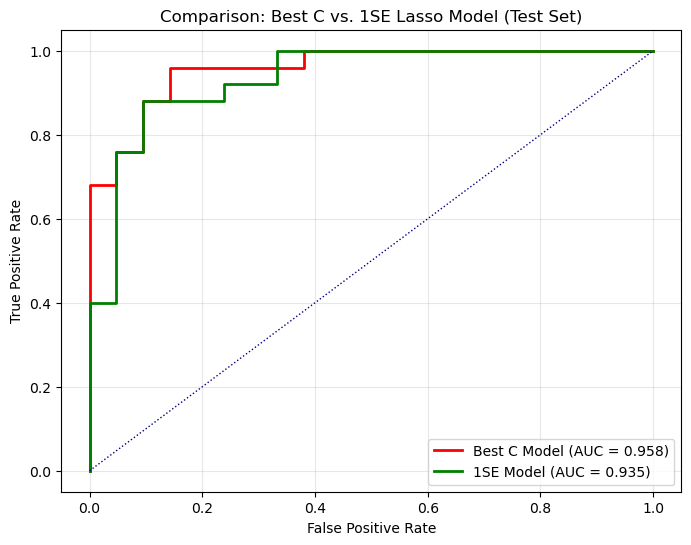

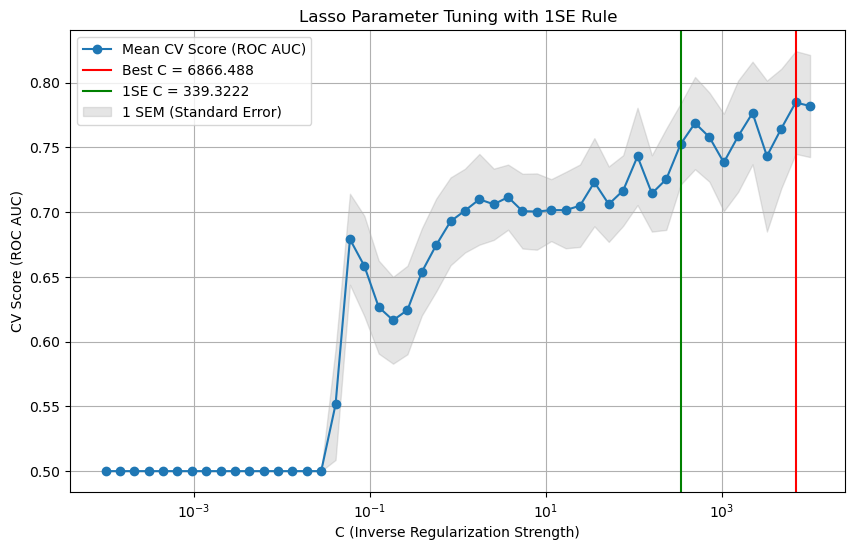

In [72]:
print(f"Re-training model with best metrics: {best_metrics}")

# Pivot
pivot_df = df.pivot(
    index="sample",
    columns="bin_id",
    values=list(best_metrics)
)
pivot_df.columns = [
    f"{metric}_{bin_id}" for metric, bin_id in pivot_df.columns
]

# Labels
y = []
strata = []
for sample_id in pivot_df.index:
    row = clinical_df[clinical_df["Extracted_ID"] == sample_id].iloc[0]
    is_healthy = row["Patient Type"].lower() == "healthy"
    target_val = 0 if is_healthy else 1
    y.append(target_val)
    if stratify == "Gender":
        strata.append(row["Gender"])
    else:
        strata.append(target_val)

y = np.array(y)
X = pivot_df
n_nans = X.isna().sum().sum()
if n_nans > 0:
    print(f"{n_nans} NaNs found in dataframe")
else:
    print("No NaNs in dataframe")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=strata,
    random_state=42,
)

# Fit
pipeline.fit(X_train, y_train)

lasso_cv = pipeline.named_steps["lasso_cv"]


# --- 1se Rule Calculation ---
# scores_[1] is of shape (n_folds, n_Cs)
mean_scores = np.mean(lasso_cv.scores_[1], axis=0)
std_scores = np.std(lasso_cv.scores_[1], axis=0)
n_folds = 5
sem_scores = std_scores / np.sqrt(n_folds)
cs = lasso_cv.Cs_

best_idx = np.argmax(mean_scores)
best_c = float(cs[best_idx])
best_score = mean_scores[best_idx]
best_sem = sem_scores[best_idx]
threshold = best_score - best_sem

# c_1se: smallest C (most parsimonious) within 1 SEM of maximum
idx_1se = np.where(mean_scores >= threshold)[0][0]
c_1se = float(cs[idx_1se])

print(f"Best C (max mean): {best_c:.6f} with AUC: {best_score:.4f}")
print(f"c_1se (parsimonious): {c_1se:.6f} (Threshold: {threshold:.4f})")


# --- STABILERES MODELL MIT C_1SE ---

stable_lasso = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=c_1se,
    max_iter=10000,
    random_state=42
)

stable_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', stable_lasso)
])



stable_pipeline.fit(X_train, y_train)
# 1. Calculate probabilities for both models (Test Set)
y_prob_best = pipeline.predict_proba(X_test)[:, 1]
y_prob_1se = stable_pipeline.predict_proba(X_test)[:, 1]

# 2. Calculate ROC values for both models
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)
fpr_1se, tpr_1se, _ = roc_curve(y_test, y_prob_1se)

auc_best = roc_auc_score(y_test, y_prob_best)
auc_1se = roc_auc_score(y_test, y_prob_1se)

# 3. Create Common Plot
plt.figure(figsize=(8, 6))

# Curve 1: Best C (e.g., in Blue)
plt.plot(fpr_best, tpr_best, color='red', lw=2, 
         label=f'Best C Model (AUC = {auc_best:.3f})')

# Kurve 2: 1SE Model (z.B. in Grün oder Orange)
plt.plot(fpr_1se, tpr_1se, color='green', lw=2,
         label=f'1SE Model (AUC = {auc_1se:.3f})')

# Diagonale (Zufallslinie)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle=':')

plt.title('Comparison: Best C vs. 1SE Lasso Model (Test Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.show()

# --- Lasso Parameter Tuning Plot ---
plt.figure(figsize=(10,6))
plt.semilogx(cs, mean_scores, marker='o', label='Mean CV Score (ROC AUC)')
plt.fill_between(cs, mean_scores - sem_scores, mean_scores + sem_scores, alpha=0.2, color='gray', label='1 SEM (Standard Error)')
plt.axvline(best_c, color='r', label=f'Best C = {best_c:.3f}')
plt.axvline(c_1se, color='g', label=f'1SE C = {c_1se:.4f}')
plt.title("Lasso Parameter Tuning with 1SE Rule")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("CV Score (ROC AUC)")
plt.legend()
plt.grid(True)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/lasso_parameter_tuning{bin_size}.png")
plt.show()

## 5.2 Training vs. Test with best model 

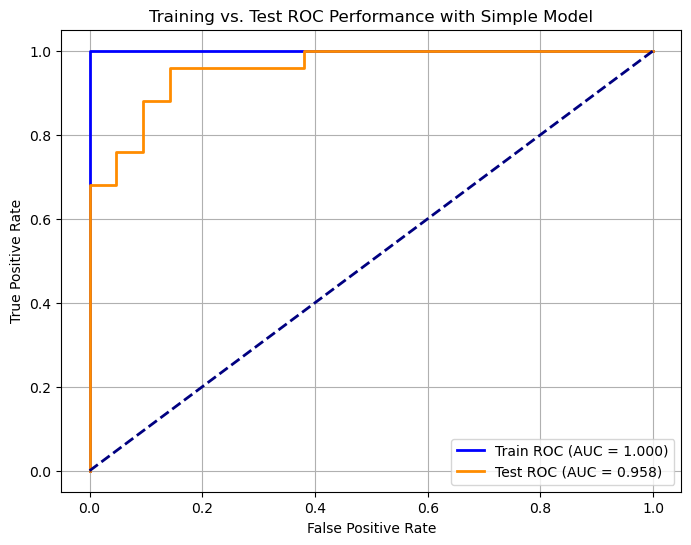

In [73]:
y_prob_train = pipeline.predict_proba(X_train)[:, 1]
y_prob_test = pipeline.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

plt.figure(figsize=(8, 6))
auc_train = roc_auc_score(y_train, y_prob_train)
auc_test = roc_auc_score(y_test, y_prob_test)
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_train:.3f})')
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {auc_test:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Training vs. Test ROC Performance with Simple Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 5.3 Training vs. Test with 1SE Model

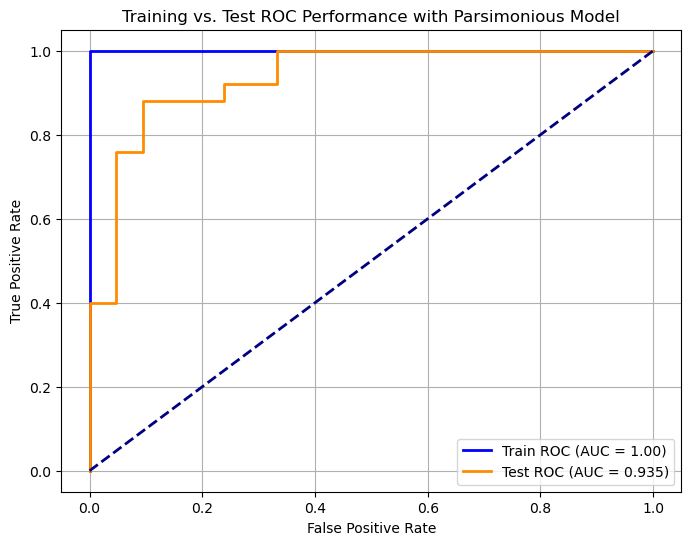

In [74]:
y_prob_train = stable_pipeline.predict_proba(X_train)[:, 1]
y_prob_test = stable_pipeline.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

auc_train = roc_auc_score(y_train, y_prob_train)
auc_test = roc_auc_score(y_test, y_prob_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {auc_test:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Training vs. Test ROC Performance with Parsimonious Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 6. Selected Important Features


## 6.1 Pipeline with best model

                Feature  Coefficient
0     mean_chr10_100000     0.001752
1    mean_chr10_1000000     0.000000
2  mean_chr10_100900000    -0.119962
3  mean_chr10_101000000     0.000000
4  mean_chr10_101400000    -0.060254
SINGLE MODEL (Best C)
Number of Important Features (Single Model): 3019

Top Features (Single Model - Positive = Indicative for Cancer):


<AxesSubplot:title={'center':'Top Features (Single Model - Positive = Indicative for Cancer)'}, ylabel='Feature'>

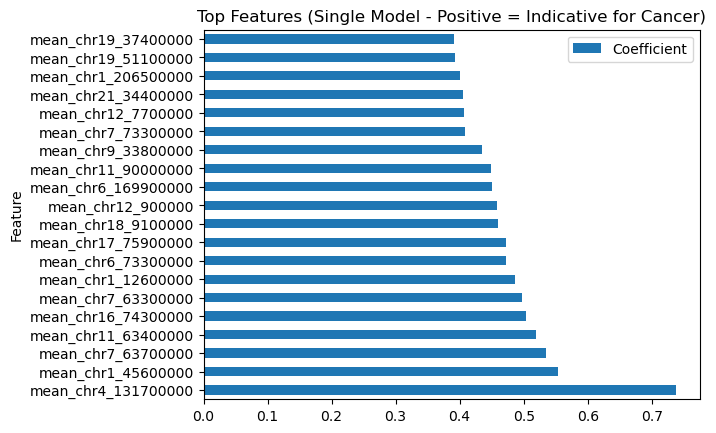

In [75]:
from cv_lasso_single_fold import cross_validation, analyze_feature_stability, plot_roc_curves, plot_auc_boxplot

lasso_model = pipeline.named_steps['lasso_cv']

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso_model.coef_[0]
})
print(coef_df.head())
important_features = coef_df[coef_df["Coefficient"] != 0].sort_values(by="Coefficient", ascending=False)

print("SINGLE MODEL (Best C)")
print(f"Number of Important Features (Single Model): {len(important_features)}")
print("\nTop Features (Single Model - Positive = Indicative for Cancer):")
important_features.head(20).plot.barh(x="Feature", y="Coefficient", title="Top Features (Single Model - Positive = Indicative for Cancer)")


## 6.2 Stable Pipeline with 1SE model 


STABLE MODEL (c_1se):
Number of Important Features (Stable Model): 1159

Top Features (Stable Model - Positive = Indicative for Cancer):


COMPARISON:
Best C Model: 3019 features selected
1SE Model:    1159 features selected
Difference:   1860 fewer features in 1SE model


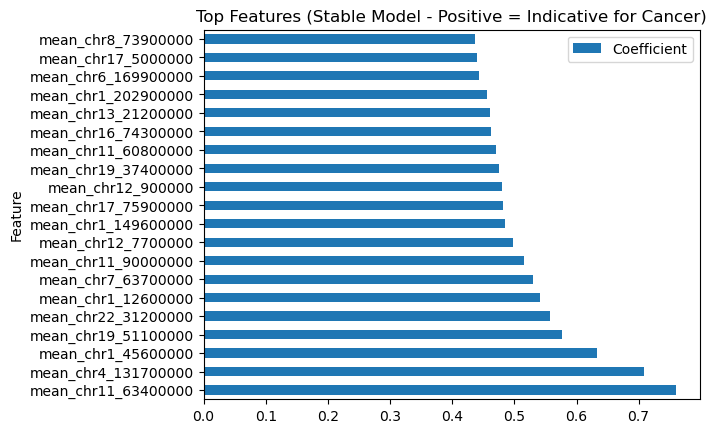

In [76]:

stable_lasso_model = stable_pipeline.named_steps['model']

stable_coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": stable_lasso_model.coef_[0]
})

stable_important_features = stable_coef_df[stable_coef_df["Coefficient"] != 0].sort_values(by="Coefficient", ascending=False)

print("STABLE MODEL (c_1se):")
print(f"Number of Important Features (Stable Model): {len(stable_important_features)}")
print(f"\nTop Features (Stable Model - Positive = Indicative for Cancer):")
stable_important_features.head(20).plot.barh(x="Feature", y="Coefficient", title="Top Features (Stable Model - Positive = Indicative for Cancer)")

print("\n")
print("COMPARISON:")
print(f"Best C Model: {len(important_features)} features selected")
print(f"1SE Model:    {len(stable_important_features)} features selected")
print(f"Difference:   {len(important_features) - len(stable_important_features)} fewer features in 1SE model")

# 7. Feature Stability Analysis (Cross-Validation) 


Running 5-Fold Cross-Validation for Feature Stability.
Fold 1/5...
  AUC = 0.690, Best C = 2222.996482526191
Fold 2/5...
  AUC = 0.678, Best C = 75.43120063354607
Fold 3/5...
  AUC = 0.722, Best C = 3237.45754281764
Fold 4/5...
  AUC = 0.868, Best C = 6866.488450042998
Fold 5/5...
  AUC = 0.769, Best C = 6866.488450042998


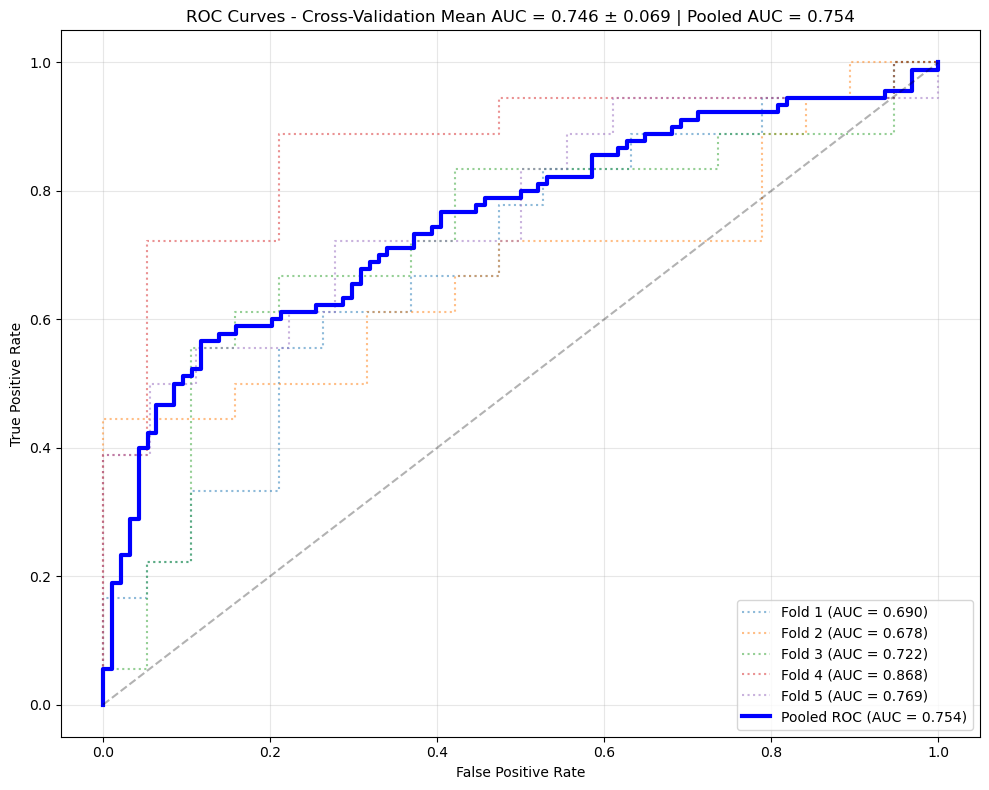

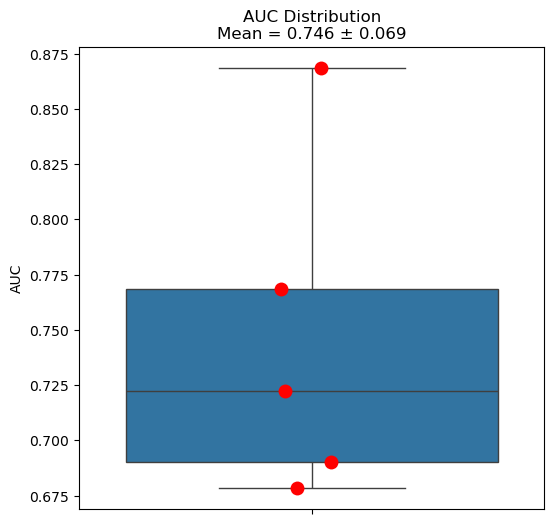

In [77]:
import importlib
import cv_lasso_single_fold
importlib.reload(cv_lasso_single_fold)
from cv_lasso_single_fold import plot_roc_curves
print("Running 5-Fold Cross-Validation for Feature Stability.")

# X and y should be available from previous cells. 
# We use X (full pivot_df before split if available, or regenerate if needed).
# Assuming X and y are the full datasets as defined before train_test_split.

# Re-verify label consistency
# hier macht es keinen sinn die stable pipeline zu nutzen, da in jedem fold mit dem gleichen c wert (c_1se) trainiert wird
cv_results = cross_validation(X_train, y_train, pipeline, n_folds=5)

# Plotte Performance
plot_roc_curves(cv_results)
plot_auc_boxplot(cv_results)


## 7.2 Table with Statistical Values

In [78]:
from cv_lasso_single_fold import print_performance_table
stat_table = print_performance_table(cv_results)
print(stat_table)

'''
Accuracy: Anteil korrekt klassifizierter Samples
Sensitivity: Wie viele Krebs-Patienten wurden erkannt (wichtig!)
Specificity: Wie viele Gesunde wurden korrekt erkannt
Precision: Von allen als "Krebs" vorhergesagten, wie viele waren wirklich Krebs
'''


   Fold       AUC  Accuracy  Sensitivity  Specificity  Precision       Best_C  \
0     1  0.690058  0.648649     0.555556     0.736842   0.666667  2222.996483   
1     2  0.678363  0.621622     0.500000     0.736842   0.642857    75.431201   
2     3  0.722222  0.675676     0.722222     0.631579   0.650000  3237.457543   
3     4  0.868421  0.783784     0.722222     0.842105   0.812500  6866.488450   
4     5  0.768519  0.666667     0.555556     0.777778   0.714286  6866.488450   
5  Mean  0.745517  0.679279     0.611111     0.745029   0.697262  3853.772425   
6   Std  0.077075  0.061959     0.103935     0.076651   0.070177  2977.753025   

    N_Features  
0  1642.000000  
1   666.000000  
2  1131.000000  
3  2576.000000  
4  1819.000000  
5  1566.800000  
6   722.687138  


'\nAccuracy: Anteil korrekt klassifizierter Samples\nSensitivity: Wie viele Krebs-Patienten wurden erkannt (wichtig!)\nSpecificity: Wie viele Gesunde wurden korrekt erkannt\nPrecision: Von allen als "Krebs" vorhergesagten, wie viele waren wirklich Krebs\n'

## 7.3 Feature Stability Analyse



Top Stable Features (Selected across multiple folds):
                  Feature  Frequency  Frequency_Percent  Mean_Coef
1287  mean_chr4_131700000          5              100.0   0.623935
175   mean_chr11_63400000          5              100.0   0.527942
934    mean_chr1_45600000          5              100.0   0.515023
1498   mean_chr7_63700000          5              100.0   0.502573
798    mean_chr1_12600000          5              100.0   0.430869


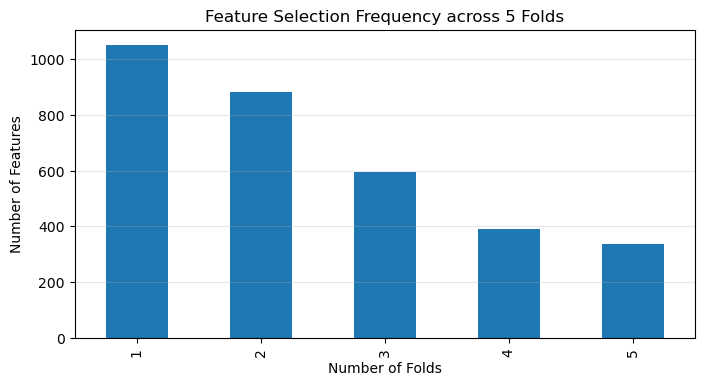

Features in ALL 5 folds: 335


In [ ]:
stability_df = analyze_feature_stability(cv_results)
n_folds = 5
stable_in_all = stability_df[stability_df['Frequency'] == n_folds]
print("\nTop Stable Features (Selected across multiple folds):")
print(stability_df.head(5))

plt.figure(figsize=(8, 4))
stability_df['Frequency'].value_counts().sort_index().plot(kind='bar')
plt.title('Feature Selection Frequency across 5 Folds')
plt.xlabel('Number of Folds')
plt.ylabel('Number of Features')
plt.grid(axis='y', alpha=0.3)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/roc_curve_{bin_size}_fold.png")
plt.show()
print(f"Features in ALL 5 folds: {len(stable_in_all)}")

## 7.4 Feature Overlap Heatmap 


Text(0.5, 1.0, 'Feature Selection Consistency')

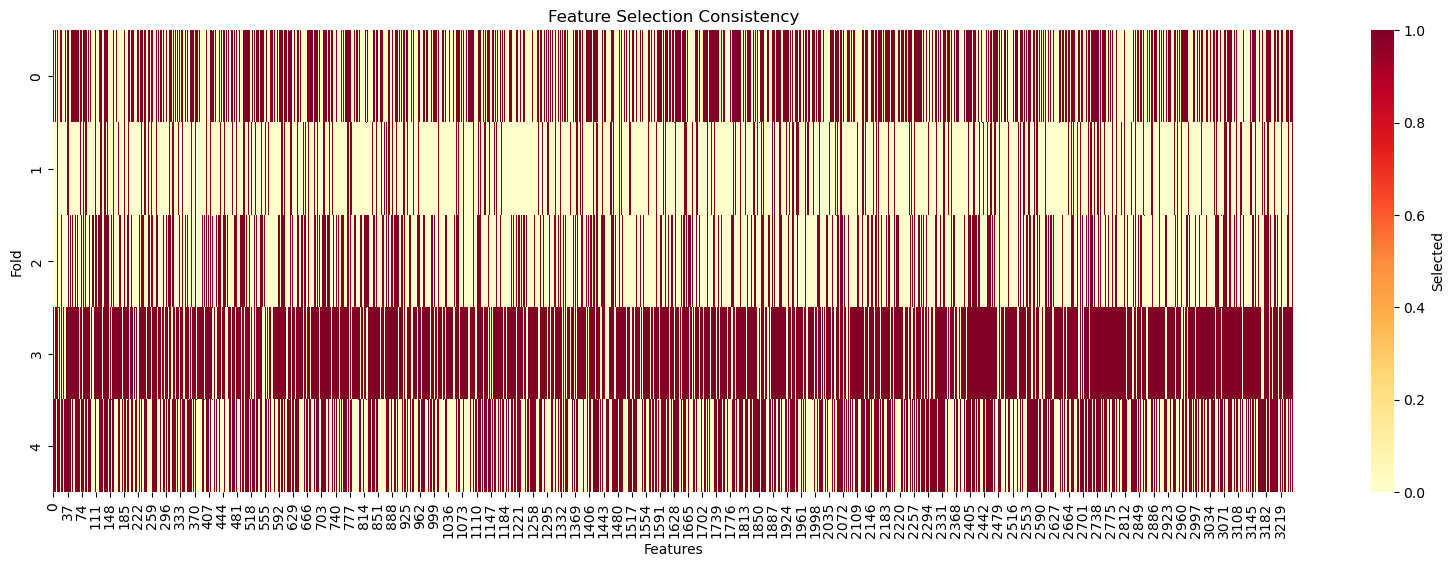

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

n_folds = len(cv_results)
all_features = set()
for e in cv_results:
    all_features.update(e['selected_features'].keys())

matrix = np.zeros((n_folds, len(all_features)))
for i, e in enumerate(cv_results):
    for j, feat in enumerate(all_features):
        if feat in e['selected_features']:
            matrix[i, j] = 1

plt.figure(figsize=(20, 6))
sns.heatmap(matrix, cmap='YlOrRd', cbar_kws={'label': 'Selected'})
plt.xlabel('Features')
plt.ylabel('Fold')
plt.title('Feature Selection Consistency')

# 8. Visualize the ROC Calculation (Label, Probability)

In [81]:
# 1. Get the probabilities for the test set 
y_prob_test = pipeline.predict_proba(X_test)[:, 1]

# 2. Create a DataFrame to map predictions to sample IDs
test_results = pd.DataFrame({
    'Sample_ID': X_test.index,
    'True_Label': y_test,
    'Probability_Cancer': y_prob_test
})

# 3. Sort the results by probability    
test_results = test_results.sort_values(by='Probability_Cancer', ascending=False).reset_index(drop=True)

# 4. Print the top 5 predictions
print("Detailed predicitions for test set:")
print(test_results.head(5))


Detailed predicitions for test set:
  Sample_ID  True_Label  Probability_Cancer
0   EE87902           1            1.000000
1   EE87888           1            1.000000
2   EE88298           1            0.999986
3   EE87886           1            0.999981
4   EE88303           1            0.999979


In [82]:
# Falsch-Negative (Krebs als gesund vorhergesagt)
fn_proben = test_results[(test_results['True_Label'] == 1) & (test_results['Probability_Cancer'] < 0.3)]

# Falsch-Positive (Gesund als Krebs vorhergesagt)
fp_proben = test_results[(test_results['True_Label'] == 0) & (test_results['Probability_Cancer'] > 0.7)]

# Merge outliers with test_results to get the probabilities
outliers_meta = pd.concat([fn_proben, fp_proben])
if not outliers_meta.empty:
    ausreisser_klinik = clinical_df.merge(outliers_meta[['Sample_ID', 'Probability_Cancer', 'True_Label']], 
                                         left_on='Extracted_ID', right_on='Sample_ID')
    print(f"Found outliers with threshold (FN < 0.3, FP > 0.7): {len(ausreisser_klinik)}")
    print(ausreisser_klinik[['Extracted_ID', 'Patient Type', 'Gender', 'Probability_Cancer']])
else:
    print("No outliers found.")


Found outliers with threshold (FN < 0.3, FP > 0.7): 5
  Extracted_ID       Patient Type Gender  Probability_Cancer
0      EE87807   Bile Duct Cancer      M            0.288801
1      EE87883  Colorectal Cancer      M            0.233631
2      EE87906     Gastric cancer      M            0.037648
3      EE88006            Healthy      M            0.989173
4      EE87956            Healthy      F            0.917423
